In [143]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict
from collections import OrderedDict
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from stock_system import IQFeed, DataUtils, ModelUtils, GridUtils, PlotUtils, TA

In [144]:
def get_features():
    x_cols = ['roc', 'rsi', 'willr', 'obv', 'stok']
    x_cols = ['roc']
    # Oscilators
    # x_osc = ['rsi', 'cci', 'stod', 'stok', 'willr']
    # x_oscd_cols = ['rsi_d', 'cci_d', 'stod_d', 'stok_d', 'willr_d']
    # # MAs
    # x_ma_cols = ['sma20', 'sma50', 'sma200', 'wma10', 'macd_d']
    # x_all_dscrete_cols = ['roc_d', 'rsi_d', 'cci_d', 'stod_d', 'stok_d', 'willr_d', 'mom_d']
    # #x_cols = ['roc', 'rsi', 'willr', 'obv', 'stok']#'mom', , 'cci',  'stod', 'macd', 'sma', 'sma50', 'wma']
    # #x_cols = ['roc']
    # x_cols = x_all_dscrete_cols + x_ma_cols
    return  x_cols

# Fit, train, and predit the model
def run_once():
    all_scores = m.predict_tscv(model, X_train, y_train)
    print '====== Cross Val Mean Scores ======'
    for key in all_scores[0].keys():
        try:
            mean_val = np.mean([d[key] for d in all_scores])
            print '- %s: %s' % (key, mean_val)
        except:
            pass

    print '====== Top feature imporance ======'
    m.print_feature_importance(model, df[get_features()])

    print '====== Predict Scores ======'
    y_pred = model.predict(X_test)
    # model.score(yhat, y_test)

    # Scores and confusion matrix
    m.print_scores(y_test, y_pred)
    m.print_standard_confusion_matrix(y_test, y_pred)

    return y_pred

def run_for_n_days_ahead(num_days):
#     model = get_model()
    scores_list = []
    for n in range(1,num_days+1):
        print '====== num days ahead: %s ======' % n
        days_ahead = -n
        df['gain_loss'] = np.roll(df['close'], days_ahead) - df['close']
        df['y_true'] = (df['gain_loss'] >= 0).astype(int)
        y = df.pop('y_true').values
        X = df.values
        X_train, X_test, y_train, y_test = m.simple_data_split(df[get_features()].values, y, test_set_size=int(df.shape[0]*.2))

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        all_scores = m.get_scores(y_test, y_pred)
        #all_scores['predict_proba'] = model.predict_proba(X_test)
        # m.print_standard_confusion_matrix(y_test, y_pred)
        # m.print_feature_importance(model, df[get_features()])
        scores_list.append(all_scores)

    return scores_list

In [150]:
db = DataUtils.DataUtils()
m = ModelUtils.ModelUtils()

symbol =  'MMM'
print 'Fitting for symbol: ', symbol

# get stock data from db as dataframe
# df = db.read_symbol_data("Select * from symbols where symbol='FB' limit 100") # Dummy data
df = db.read_symbol_data(symbol, 'h')
# run expinential smoothing
df = db.run_exp_smooth(df, alpha=.5)
# run technical analysis, add columns
df = TA.run_techicals(df)
# subset out rows that have nan's
# df = df[np.isfinite(df['macd_d'])]
for name in df.columns:
    df = df[df[name].notnull()]
# Imput - fillna with 0 for now...
#df = df.fillna(0)
# Number of days ahead to see if the price moved up or down
days_ahead = -30
df['gain_loss'] = np.roll(df['close'], days_ahead) - df['close']
df['y_true'] = (df['gain_loss'] >= 0).astype(int)
# Drop the last row?
df = df[:-1]

##############
# Use only relevant columns for the model in X
y = df.pop('y_true').values
X = df.values

# Split
X_train, X_test, y_train, y_test = m.simple_data_split(df[get_features()].values, y, test_set_size=int(df.shape[0]*.2))

# Instantiate model(s)
# Results from grid search
# {'max_features': 'log2', 'n_estimators': 1000, 'min_samples_leaf': 10}
model = m.get_model('svc')

#y_pred = run_once()
all_scores = run_for_n_days_ahead(90)


Fitting for symbol:  MMM
====== num days ahead: 1 ======
====== num days ahead: 2 ======
====== num days ahead: 3 ======
====== num days ahead: 4 ======
====== num days ahead: 5 ======
====== num days ahead: 6 ======
====== num days ahead: 7 ======
====== num days ahead: 8 ======
====== num days ahead: 9 ======
====== num days ahead: 10 ======
====== num days ahead: 11 ======
====== num days ahead: 12 ======
====== num days ahead: 13 ======
====== num days ahead: 14 ======
====== num days ahead: 15 ======
====== num days ahead: 16 ======
====== num days ahead: 17 ======
====== num days ahead: 18 ======
====== num days ahead: 19 ======
====== num days ahead: 20 ======
====== num days ahead: 21 ======
====== num days ahead: 22 ======
====== num days ahead: 23 ======
====== num days ahead: 24 ======
====== num days ahead: 25 ======
====== num days ahead: 26 ======
====== num days ahead: 27 ======
====== num days ahead: 28 ======
====== num days ahead: 29 ======
====== num days ahead: 30 =

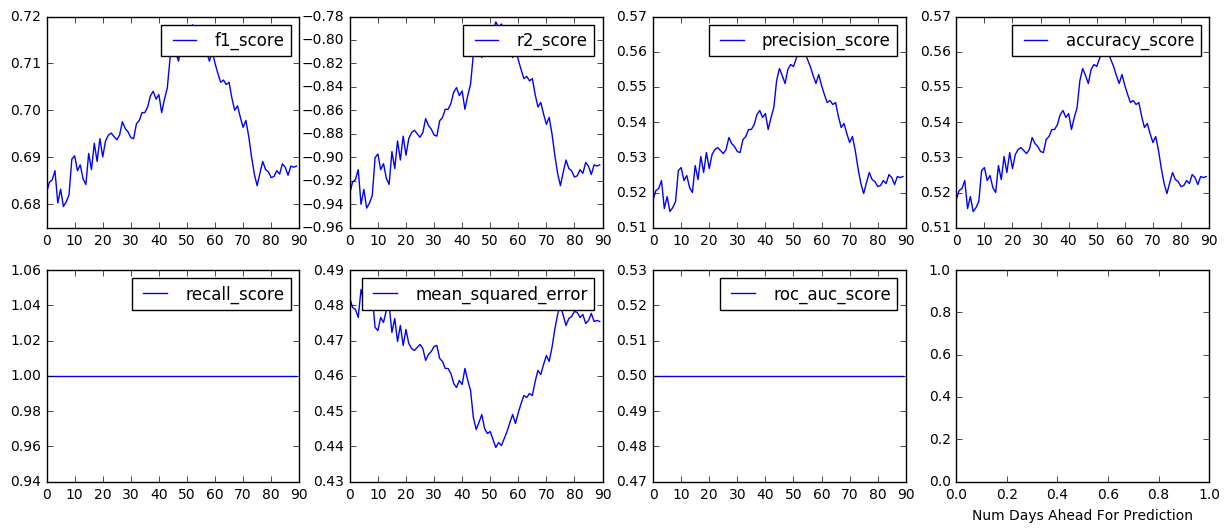

In [151]:
PlotUtils.plot_meteric_scores(all_scores)  # SVC

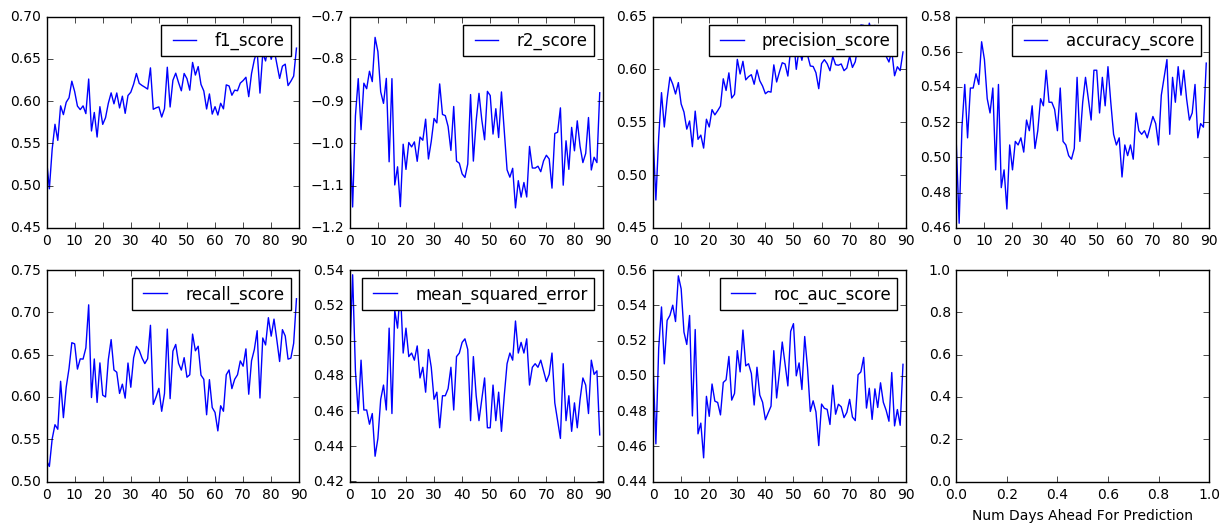

In [120]:
PlotUtils.plot_meteric_scores(all_scores)  # Random Foreset

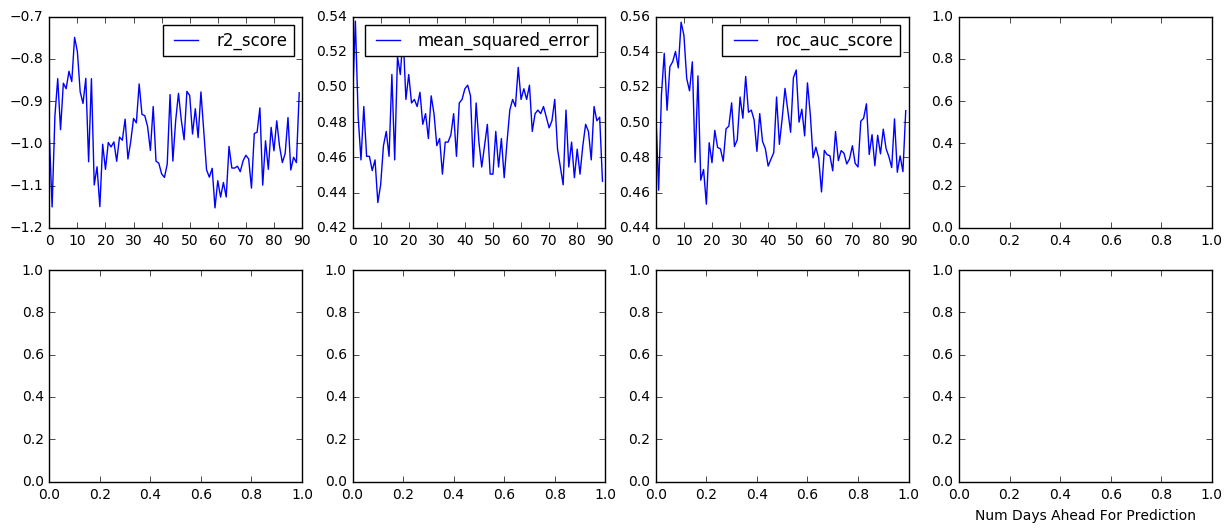

In [121]:
#all_scores[0]
names = all_scores[0].keys()

for d in all_scores:
    d.pop('accuracy_score', None)
    d.pop('f1_score', None)
    d.pop('precision_score', None)
    d.pop('recall_score', None)

PlotUtils.plot_meteric_scores(all_scores)  # GB

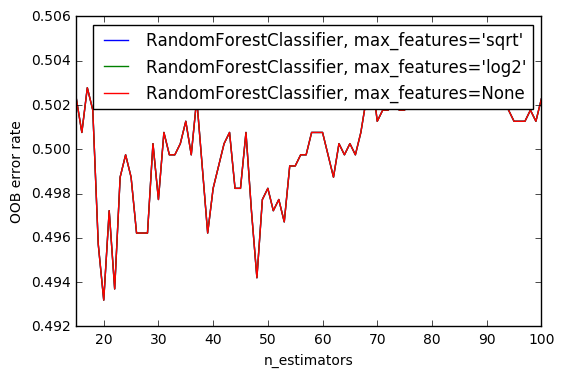

In [122]:
reload(PlotUtils)
PlotUtils.plot_oob_error(X_train, y_train)

In [105]:
# rf.predict_proba(X_test)[:,1]

In [109]:
reload(PlotUtils)
#model = get_model()
#all_scores = m.predict_tscv(model, X_train, y_train)
probabilities = model.predict_proba(X_test)[:,1]
# probabilities

AttributeError: predict_proba is not available when  probability=False

In [110]:
PlotUtils.plot_roc_curve(probabilities, y_test)

#     plt.plot(fpr, tpr)
#     plt.xlabel("False Positive Rate (1 - Specificity)")
#     plt.ylabel("True Positive Rate (Sensitivity, Recall)")
#     plt.title("ROC plot of fake data")
#     plt.show()

NameError: name 'probabilities' is not defined

In [111]:
np.sort(probabilities)

NameError: name 'probabilities' is not defined

In [112]:
reload(PlotUtils)
tpr, fpr, thresholds = PlotUtils.roc_curve(probabilities, y_test)
# fpr, tpr

NameError: name 'probabilities' is not defined

Logistic:
	Brier: 0.247
	Precision: 0.560
	Recall: 1.000
	F1: 0.718

RF:
	Brier: 0.297
	Precision: 0.560
	Recall: 1.000
	F1: 0.718

RF + Isotonic:
	Brier: 0.247
	Precision: 0.559
	Recall: 0.998
	F1: 0.717

RF + Sigmoid:
	Brier: 0.247
	Precision: 0.560
	Recall: 0.999
	F1: 0.718



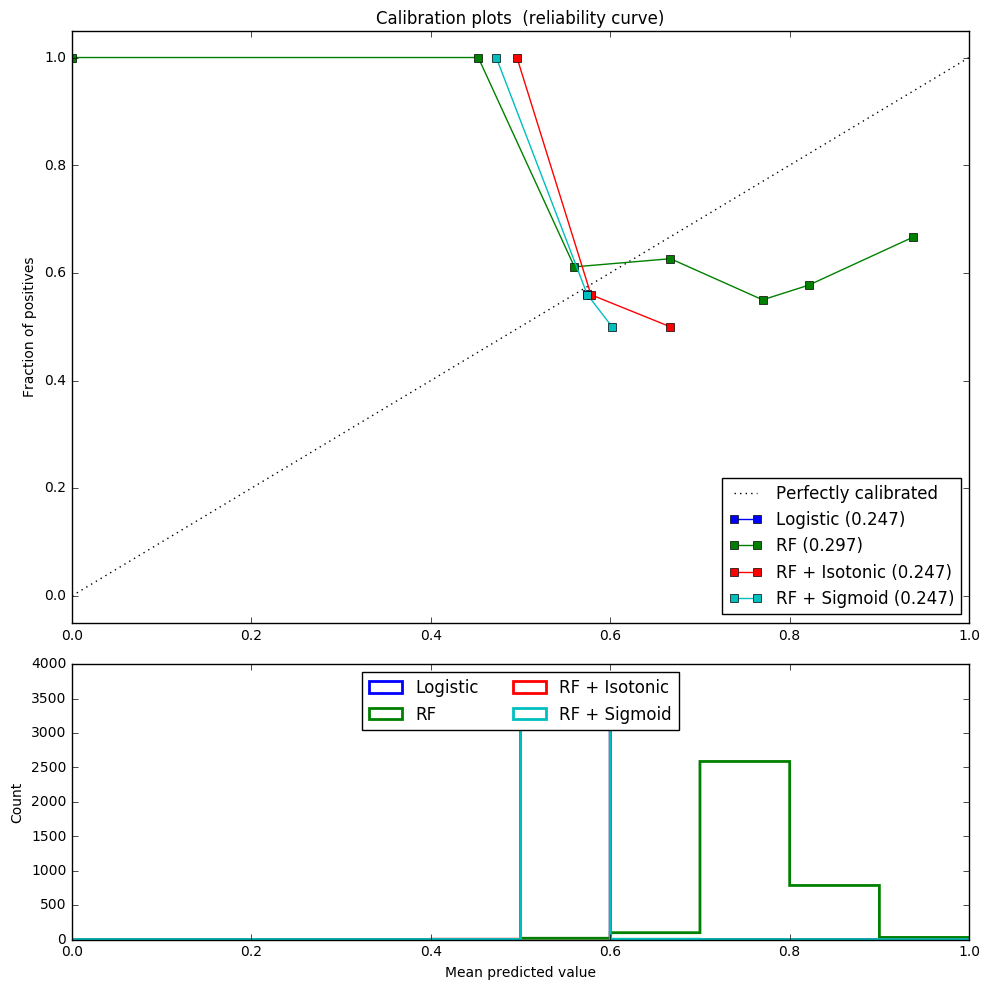

In [154]:
days_ahead = -55
df['gain_loss'] = np.roll(df['close'], days_ahead) - df['close']
df['y_true'] = (df['gain_loss'] >= 0).astype(int)
y = df.pop('y_true').values
X = df.values
X_train, X_test, y_train, y_test = m.simple_data_split(df[get_features()].values, y, test_set_size=int(df.shape[0]*.2))

model = m.get_model('svc')
PlotUtils.plot_calibration_curve(model,'RF', 1, X_train, X_test, y_train, y_test)

In [92]:
pd.DataFrame(X_train).describe()

,0,1,2
count,1981.000000,1981.000000,1981.000000
mean,0.000366,54.558706,-40.552245
std,0.010153,15.026304,38.154735
min,-0.056289,13.206558,-99.967477
25%,-0.004164,44.412485,-78.125233
50%,0.000668,55.836884,-29.670061
75%,0.005411,65.549946,-1.417482
max,0.051681,88.013819,8.722655


In [86]:
get_features()

['roc', 'rsi', 'willr']

In [87]:
np.isfinite(y_train).all()

True

In [88]:
X = y_test
if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
        and not np.isfinite(X).all()):
    raise ValueError("Input contains NaN, infinity"
                     " or a value too large for %r." % X.dtype)

In [89]:
X.dtype.char in np.typecodes['AllFloat']

False

In [90]:
(X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
        and not np.isfinite(X).all())

False

In [148]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1,

In [114]:
y_pred

NameError: name 'y_pred' is not defined